In [56]:
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

# Import Dataset

       year  day  temperature  bloom  full_bloom  week_mean  2week_mean  \
0      1961    1         -6.9    123         128  -6.900000   -6.900000   
1      1961    2         -7.0    122         127  -6.950000   -6.950000   
2      1961    3         -3.0    121         126  -5.633333   -5.633333   
3      1961    4         -3.2    120         125  -5.025000   -5.025000   
4      1961    5         -6.6    119         124  -5.340000   -5.340000   
...     ...  ...          ...    ...         ...        ...         ...   
22640  2022  361          1.5   -248        -246   1.000000   -1.907143   
22641  2022  362          0.8   -249        -247   1.400000   -1.585714   
22642  2022  363         -2.3   -250        -248   1.171429   -1.392857   
22643  2022  364         -1.8   -251        -249   0.800000   -1.164286   
22644  2022  365          0.3   -252        -250   0.471429   -0.892857   

       4week_mean  8week_mean  16week_mean  accumulated  
0       -6.900000   -6.900000    -6.90000

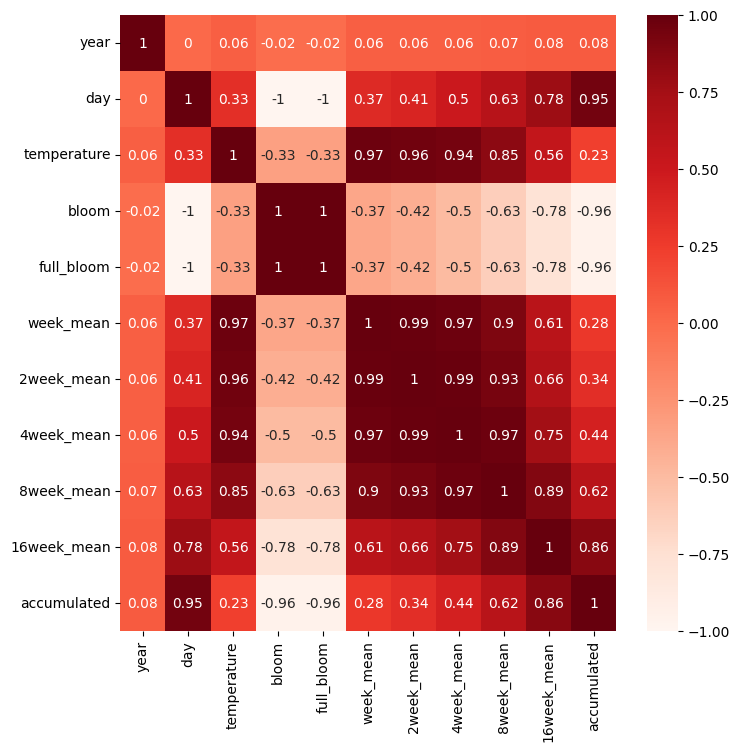

In [90]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as mplot

# Import dataset
history = pd.read_csv("historic.csv")
print(history)

# Correlation Mapping of features
mplot.figure(figsize=(8, 8))
sns.heatmap(history.corr().round(2), annot=True, cmap=mplot.cm.Reds)
mplot.show()

# Regressor Training and Prediction

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Prepares dependent and independent variables
x = pd.DataFrame(history.drop(columns=["bloom", "full_bloom", "year"])) # Drop features that have low correlation?
# y = pd.DataFrame(history[["bloom", "full_bloom"]])
y = pd.DataFrame(history["full_bloom"])
# features = x[:-365] #Exclude 2022?
# target = y[:-365]
features = x
target = y


# Split data for train and test
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state = 0)

# Create and train regressor
# model = RandomForestRegressor(n_estimators = 100, max_depth = 14, random_state = 40) # 90, 16 | 500, 12
# model = DecisionTreeRegressor()
# model = RandomForestRegressor()
model = GradientBoostingRegressor(n_estimators = 600, max_depth = 5, random_state = 40)
# model = HistGradientBoostingRegressor()
# model = GradientBoostingRegressor(random_state = 40)
# model = AdaBoostRegressor(random_state = 40)
# model = LinearRegression()

model.fit(x_train, y_train)
predict = model.predict(x_test)
print("MSE: ", mean_squared_error(y_test, predict))
print("MAE: ", mean_absolute_error(y_test, predict))
print("R\u00b2: ", r2_score(y_test, predict))

C:\Users\20ngu\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MSE:  14.075786454530746
MAE:  2.8799176678626033
R²:  0.9987558151932535


Off by Average Days:  9.796124247195413


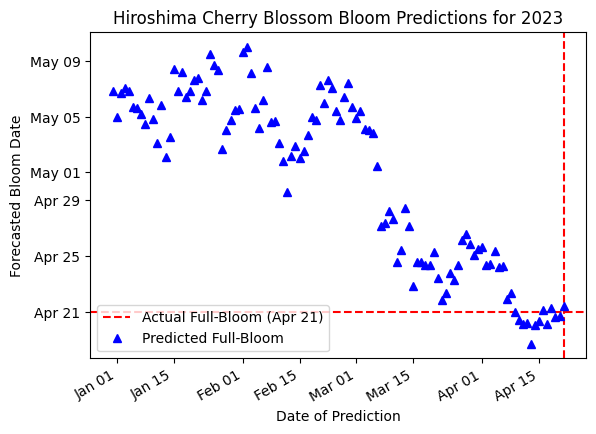

In [93]:
import datetime
import matplotlib.dates as mdates

# Import most recent data for prediction
current = pd.read_csv("predict.csv")
current = pd.DataFrame(current.drop(columns=['year']))


# Set to 2023 for most current data, otherwise, use historic data
pastyear = 2023

# Actual bloom date day-of-year to plot (Value here does not matter if looking at historic data)
actualday = 111
# Sapporo = 111
# Sendai = 90
# Tokyo = 81
# Nagoya = 86
# Hiroshima = 87
# Fukuoka = 85

# Use this to see how well the model fits with previous years
if pastyear <= 2022:
    filteredPredict = history[history['year'] == pastyear]
    actualday = filteredPredict.iloc[0, filteredPredict.columns.get_loc("full_bloom")] + 1
    offset = 0
    for i in range(1, 2022 - pastyear, 1):
        try:
            isleapyear = datetime(2022 - i, 2, 29)
            offset = offset + 366
        except:
            offset = offset + 365
    current = x[22280-offset : 22645-offset]


# Generates predictions for every day of the current year
predictions = model.predict(current)
predfullbloom = predictions.squeeze() + np.arange(1, 1 + len(predictions))
# predbloom, predfullbloom = np.split(predictions, 2, axis=1)
# predbloom = predbloom.squeeze() + np.arange(1, 1 + len(predbloom))
# predfullbloom = predfullbloom.squeeze() + np.arange(1, 1 + len(predfullbloom))


print("Off by Average Days: ", mean_absolute_error(np.full(len(predfullbloom), actualday)[:-(142-actualday)], predfullbloom[:-(142-actualday)]))

# Plots the predictions
mplot.figure()

startingday = datetime.datetime(year=pastyear - 1, month=12, day=31)
actualdayformatted = startingday + datetime.timedelta(days=actualday)

mplot.axhline(y = actualdayformatted, color="red", linestyle='--', label="Actual Full-Bloom (" + actualdayformatted.strftime('%b %d') + ")")
mplot.axvline(x = actualdayformatted, color="red", linestyle='--')
# mplot.plot(predbloom, "bv", label="Predicted Flowering")

predfullbloom = predfullbloom[:-(142-actualday)] #
microsecondsperday = 24 * 60 * 60 * 1e6
predfullbloom = [startingday + datetime.timedelta(microseconds = int(x * microsecondsperday)) for x in predfullbloom]

dateslist = np.array([startingday + datetime.timedelta(days=i) for i in range(len(predfullbloom))])

mplot.plot(dateslist, predfullbloom, "b^", label="Predicted Full-Bloom")

mplot.ylabel("Forecasted Bloom Date")
mplot.xlabel("Date of Prediction")
mplot.legend(loc="best")
mplot.title("Hiroshima Cherry Blossom Bloom Predictions for " + str(pastyear))
mplot.xticks(rotation='vertical')

mplot.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
mplot.gcf().autofmt_xdate()

mplot.gca().yaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

mplot.show()

# print("Off by Average Days: ", mean_absolute_error(np.full(len(predfullbloom), actualday), predfullbloom))

In [ ]:
# Notes: 
# GradientBoostingRegressor with 400 n_estimators and 4 depth yields best result so far

In [95]:

# Makes the prediction    
# result = model.predict(current[onday-1 : onday])
# print("Starting Prediction Day: ", datetime.strptime(str(pastyear) + ' ' + str(onday), '%Y %j').strftime('%m-%d-%Y'), '\n')
print("15-day Prediction Date: ", predfullbloom[actualday - 15])
print("30-day Prediction Date: ", predfullbloom[actualday - 30])
# print("Predicted Full-Bloom Date: ", datetime.strptime(str(pastyear) + ' ' + str(round(result[0]) + onday), '%Y %j').strftime('%m-%d-%Y'))

print("Actual Full-Bloom Date: ", actualdayformatted)

15-day Prediction Date:  2023-04-24 07:35:56.653099
30-day Prediction Date:  2023-04-21 20:30:45.861005
Actual Full-Bloom Date:  2023-04-21 00:00:00
